## Importing libraries

In [1]:
import numpy as np
import random
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# Customized functions
from backpropagation import backPropagation, loss_function
from model.mlp import MLP

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from utils import metrics_mlp

np.random.seed(0)

## Loading data

In [2]:
mnist = fetch_openml("mnist_784")
X, y = mnist.data, mnist.target.astype(int)

As we can see in the following histogram, our samples are almost well balanced between classes

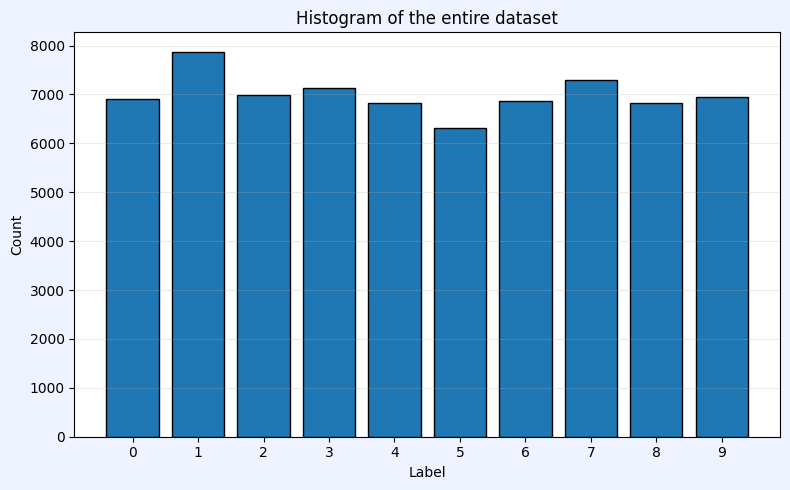

In [3]:
counts = np.bincount(y.to_numpy(), minlength=10)

plt.figure(figsize=(8, 5), facecolor="#eef3ff")
plt.bar(range(10), counts, width=0.8, edgecolor="black")

plt.title("Histogram of the entire dataset")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(range(10))
plt.grid(axis="y", alpha=0.25)

plt.tight_layout()
plt.show()

## Preprocessing data

In [4]:
# Normalizing the data
X = X / 255.0

# Splitting and transforming the data to a suitable type and form
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
y_train_, y_test = y_train.to_numpy(), y_test.to_numpy()
X_train_ = X_train.copy()

Judging by the following plot, after splitting the dataset the classes remain well balaced.

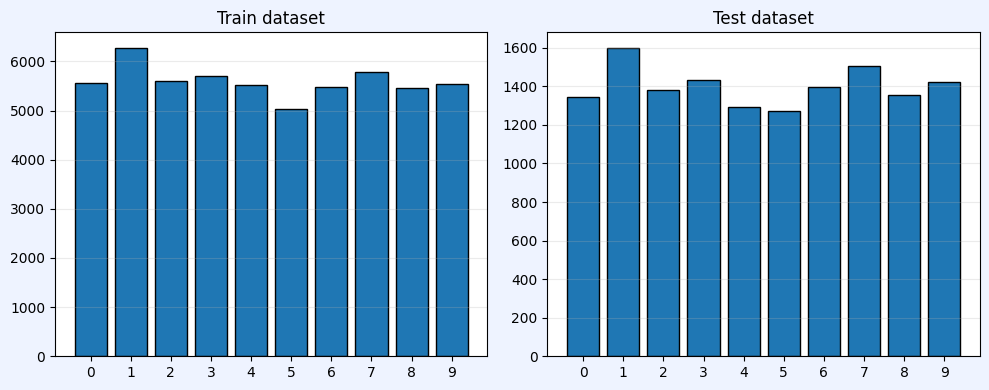

In [5]:
counts1 = np.bincount(y_train_, minlength=10)
counts2 = np.bincount(y_test, minlength=10)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), facecolor="#eef3ff")

axes[0].bar(np.arange(10), counts1, width=0.8, edgecolor="black")
axes[0].set_title("Train dataset")
axes[0].set_xticks(np.arange(10))
axes[0].grid(axis="y", alpha=0.25)

axes[1].bar(np.arange(10), counts2, width=0.8, edgecolor="black")
axes[1].set_title("Test dataset")
axes[1].set_xticks(np.arange(10))
axes[1].grid(axis="y", alpha=0.25)

plt.tight_layout()
plt.show()

In [6]:
# Creating one-hot vectors
encoder = OneHotEncoder(sparse_output=False) # sparse_output=False to obtain a dense matrix
y_train = encoder.fit_transform(y_train_.reshape(-1, 1))

## Loading MLP model

In [7]:
num_features = X_train.shape[1]
config = {
    'input_size': num_features,
    'hidden_size_1': 100,
    'hidden_size_2': 50,
    'output_size': 10,
}

mlp = MLP(config)

## Metrics without training
As expected, all the metrics are low. It is worth noting that the accuracy is $\approx 0.1$, which is expected when the 10 different labels are assigned randomly to each sample.

These plots show us that almost well balance, there is no so much diference between the percentage of each class

In [8]:
print("Train dataset")
print(metrics_mlp(mlp, X_train_, y_train_)[0])

Train dataset
              precision    recall  f1-score   support

           0       0.02      0.00      0.00      5560
           1       0.20      0.20      0.20      6277
           2       0.22      0.20      0.21      5610
           3       0.13      0.00      0.00      5708
           4       0.02      0.00      0.00      5529
           5       0.12      0.57      0.19      5040
           6       0.03      0.00      0.01      5480
           7       0.35      0.04      0.07      5790
           8       0.12      0.37      0.18      5468
           9       0.06      0.02      0.03      5538

    accuracy                           0.14     56000
   macro avg       0.13      0.14      0.09     56000
weighted avg       0.13      0.14      0.09     56000



In [9]:
print("Test dataset")
print(metrics_mlp(mlp, X_test, y_test)[0])

Test dataset
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1343
           1       0.19      0.19      0.19      1600
           2       0.20      0.19      0.19      1380
           3       0.00      0.00      0.00      1433
           4       0.00      0.00      0.00      1295
           5       0.12      0.58      0.20      1273
           6       0.02      0.00      0.01      1396
           7       0.33      0.03      0.06      1503
           8       0.12      0.38      0.18      1357
           9       0.09      0.02      0.04      1420

    accuracy                           0.13     14000
   macro avg       0.11      0.14      0.09     14000
weighted avg       0.11      0.13      0.09     14000



With the following confusion matrices we can discover a preference of our model for certain labels, what could be due to a bias in the initilization of the weights of our model but in general terms is not an unexpected behavior

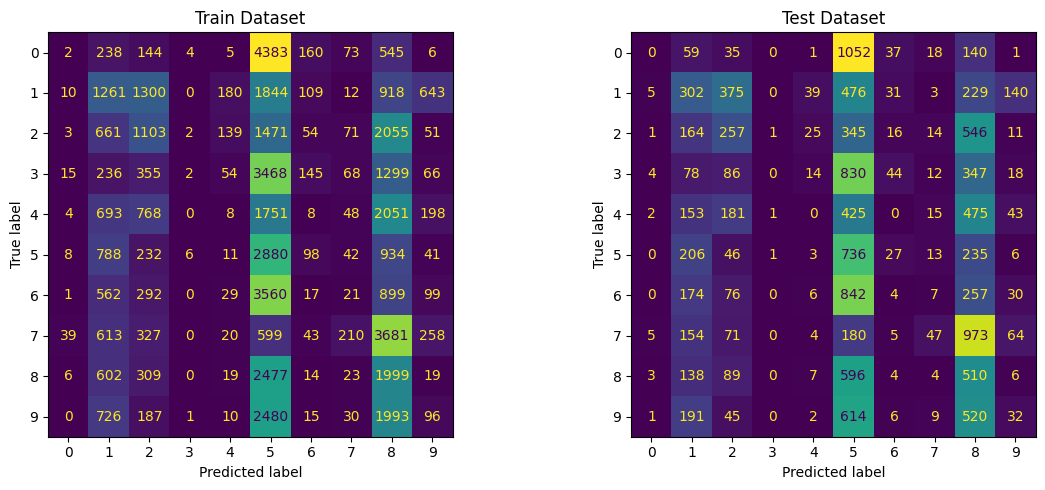

In [10]:
cm_train = confusion_matrix(y_train_, mlp.eval(X_train_))
cm_test = confusion_matrix(y_test, mlp.eval(X_test))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp1.plot(ax=axes[0], colorbar=False)
axes[0].set_title("Train Dataset")

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp2.plot(ax=axes[1], colorbar=False)
axes[1].set_title("Test Dataset")

plt.tight_layout()
plt.show()

### backpropagation algorithm instantiation

In [11]:
learning_rate = 1e-3
backpropagation = backPropagation(learning_rate)

## Training

In [12]:
epochs = 10
batch_size = 256

epoch_metrics = []


epoch_metrics.append(metrics_mlp(mlp, X_train_, y_train_)+[0])

for epoch in range(epochs):
    # shuffling the data to stocastich gradient descent
    indices = np.random.permutation(X_train.shape[0])

    X_train = X_train[indices]
    y_train = y_train[indices]
    
    total_loss = 0
    for i in range(0, X_train.shape[0], batch_size):
        # data batch
        images = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]

        # Forward
        labels_pred = mlp.forward(images)

        # computing the loss
        loss = loss_function(labels, labels_pred)
        total_loss += loss

        # Backpropagation and gradient descent
        backpropagation.backward(labels_pred, labels, images, mlp.model_weights, mlp.memory)

    # average loss
    avg_loss = total_loss / X_train.shape[0]

    epoch_metrics.append(metrics_mlp(mlp, X_train_, y_train_)+[avg_loss])
    
    # avance
    print(f"Epoch {epoch + 1}, Loss: {avg_loss}")

Epoch 1, Loss: 0.4935587628271472
Epoch 2, Loss: 0.2013831645969526
Epoch 3, Loss: 0.14552437449472183
Epoch 4, Loss: 0.11762284312906719
Epoch 5, Loss: 0.09745103811415677
Epoch 6, Loss: 0.08215456972824796
Epoch 7, Loss: 0.07359203714095638
Epoch 8, Loss: 0.06401009929956522
Epoch 9, Loss: 0.05699059102730228
Epoch 10, Loss: 0.05042325475724414


## Examining the Training

As we can observe in the next plot, our model is learning such that the loss is reduce in each epoch.

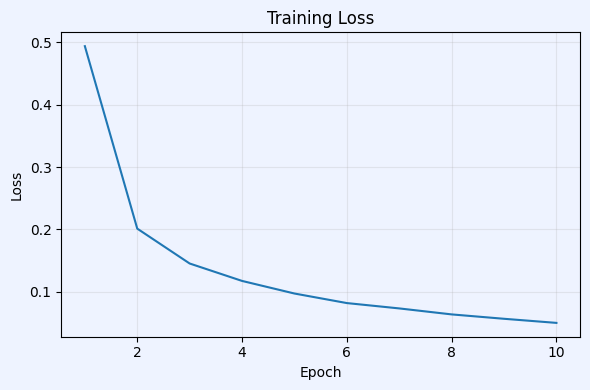

In [13]:
training_loss = [epoch_metrics[i+1][2] for i in range(10)]
fig, ax = plt.subplots(figsize=(6, 4), facecolor="#eef3ff")
ax.set_facecolor("#eef3ff")

ax.plot(range(1,11), training_loss)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training Loss")
ax.grid(alpha=0.25)

plt.tight_layout()

plt.show()


After 10 epochs our model have an almost perfect performance in the training dataset

In [14]:
len(epoch_metrics)

11

On the other hand, the performance over the test dataset is a bit worse compared with the evaluations on the train dataset, but are still so good.

In [15]:
print(metrics_mlp(mlp, X_test, y_test)[0])

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1343
           1       0.98      0.99      0.99      1600
           2       0.96      0.97      0.97      1380
           3       0.97      0.97      0.97      1433
           4       0.96      0.99      0.97      1295
           5       0.98      0.96      0.97      1273
           6       0.98      0.98      0.98      1396
           7       0.98      0.97      0.98      1503
           8       0.97      0.95      0.96      1357
           9       0.97      0.96      0.96      1420

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000



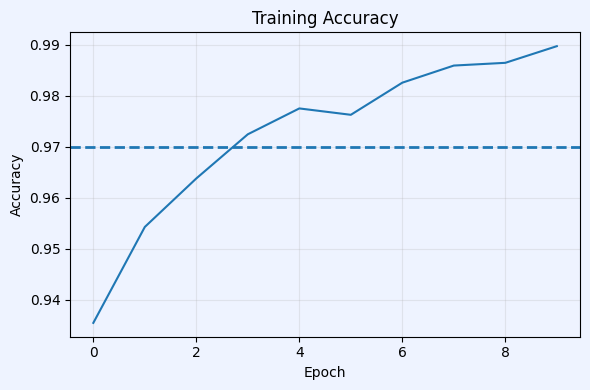

In [16]:
training_accuracy = [epoch_metrics[i+1][1]['accuracy'] for i in range(10)]

fig, ax = plt.subplots(figsize=(6, 4), facecolor="#eef3ff")
ax.set_facecolor("#eef3ff")

ax.plot(range(10), training_accuracy)
ax.axhline(y=0.97, linestyle="--", linewidth=2)

ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_title("Training Accuracy")
ax.grid(alpha=0.25)

plt.tight_layout()


plt.show()


Plotting the (macro/weighted) average precision/recal/f1 score evolution during the training we can discover a consistent behavior between them. This could be due to our data is well balanced.

Additionally, we add an horizontal line to mark the value of the trained model over the test dataset.

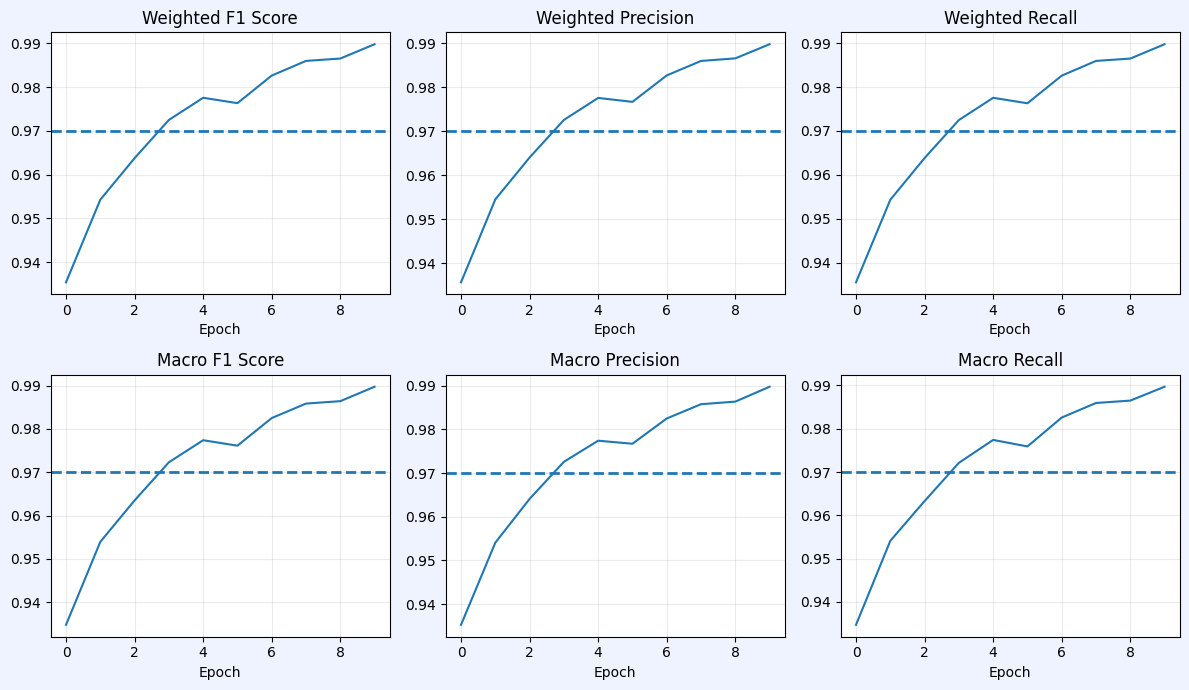

In [17]:
training_weighted_precision = [epoch_metrics[i+1][1]['weighted avg']['precision'] for i in range(10)]
training_weighted_recall = [epoch_metrics[i+1][1]['weighted avg']['recall'] for i in range(10)]
training_weighted_f1_score = [epoch_metrics[i+1][1]['weighted avg']['f1-score'] for i in range(10)]

training_macro_precision = [epoch_metrics[i+1][1]['macro avg']['precision'] for i in range(10)]
training_macro_recall = [epoch_metrics[i+1][1]['macro avg']['recall'] for i in range(10)]
training_macro_f1_score = [epoch_metrics[i+1][1]['macro avg']['f1-score'] for i in range(10)]

fig, axes = plt.subplots(2, 3, figsize=(12, 7), facecolor="#eef3ff")
axes = axes.ravel()

metrics = [
    (training_weighted_f1_score, "Weighted F1 Score"),
    (training_weighted_precision, "Weighted Precision"),
    (training_weighted_recall, "Weighted Recall"),
    (training_macro_f1_score, "Macro F1 Score"),
    (training_macro_precision, "Macro Precision"),
    (training_macro_recall, "Macro Recall"),
]

for ax, (data, title) in zip(axes, metrics):
    ax.plot(range(10), data)
    ax.axhline(y=0.97, linestyle="--", linewidth=2)
    ax.set_title(title)
    ax.set_xlabel("Epoch")
    ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()


Ultimately, based in these confusion matrices we can conclude that after the training our model learned the necessary patterns to have a good performance classifing the digits.

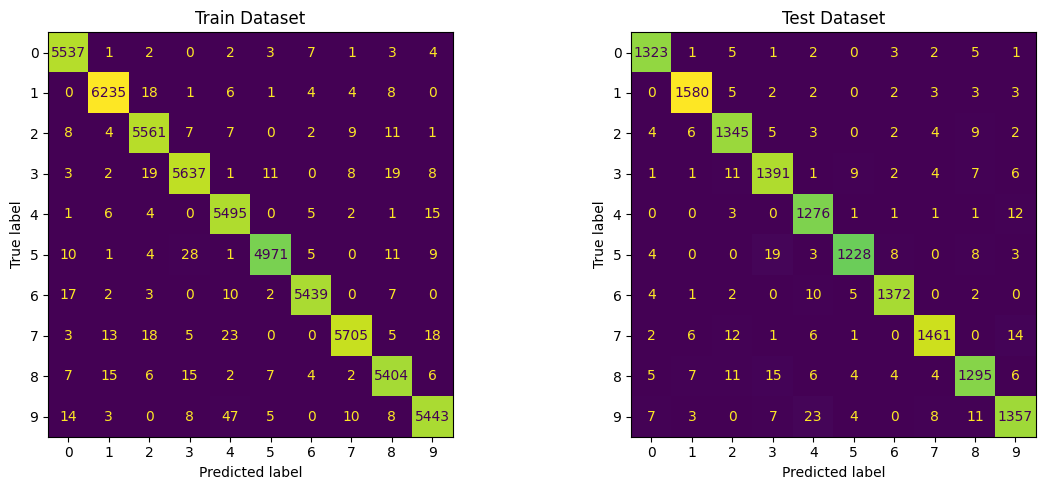

In [18]:
cm_train = confusion_matrix(y_train_, mlp.eval(X_train_))
cm_test = confusion_matrix(y_test, mlp.eval(X_test))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp1.plot(ax=axes[0], colorbar=False)
axes[0].set_title("Train Dataset")

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp2.plot(ax=axes[1], colorbar=False)
axes[1].set_title("Test Dataset")

plt.tight_layout()
plt.show()

## Inference

We randomly pick 3 samples from the test dataset to make inference and plot the result

In [21]:
indices = np.random.randint(X_test.shape[0], size=3)
images = X_test[indices]
labels = y_test[indices]
predictions =  mlp.eval(images)
images = images.reshape(3, 28, 28)

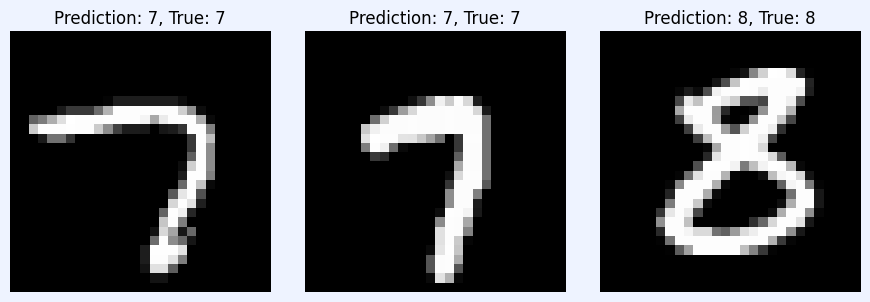

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3), facecolor="#eef3ff")

for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap="gray")
    ax.set_title(f"Prediction: {predictions[i].item()}, True: {labels[i].item()}")
    ax.axis("off")  # quita ejes para que se vea limpio

plt.tight_layout()
plt.show()